# 1. Business Problem

- TopBank empresa de serviços bancários. Ela atua principalmente nos países da Europa. 
- Oferecendo produtos financeiros, desde contas bancárias até investimentos, passando por alguns tipos de seguros e produto de investimento.
- Produto principal: conta sem custo para o cliente com vigência de 12 meses, o cliente precisa renovar o contrato dessa conta para continuar utilizando pelos próximos 12 meses.
- Lucro por conda de cliente:
    - 15% do salario estimado, para cliente com salario menor que a media.
    - 20% do salaro estimado, para clientes com salario maior que a media. 

***Problemas***
- A taxa de clientes cancelando suas contas subiu significantemente nos ultimos meses. 

***Objetivo***
- Diminur a taxa de evasão dos clientes, ou seja, impedir que o cliente cancele e não renove por mais 12 meses. 

# 2.0 Solution Planning

## 2.1 Planejamento da Entrega

1. Resposta para o problema:
- Probabilidade do cliente entrar em Churn. 

2. Formato de entrega:
- Tabela do cliente com uma coluna de score

3. Local de entrega: 
- Api envia base de dados. (Streamlit) 

## 2.2 Planejamento do Processo 

1. Passos:
- Analise descritiva

## 2.3 Planejamento da Entrada

1. Fonte de dados: 
- Kagle: https://www.kaggle.com/mervetorkan/churndataset

2. Ferramentas: 
- python 3.8
- jupyter notebook 
- pycharm 
- Heroku 
- Streamlit 


#  3.0 Imports

In [1]:
# data manipulatinon 
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder

#Statystic 
import scipy as misc
from scipy import stats

#text edit 
import inflection

#graph 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# Machine Learning Models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

# Machine Learning Visualization 
from yellowbrick.features        import ParallelCoordinates
from yellowbrick.classifier      import ClassificationReport
from yellowbrick.contrib.wrapper import wrap

# Metrics
from sklearn.model_selection import cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
import scikitplot as skplt

# files
import pickle

## 3.1 Helper Functions 

In [2]:
def cramer_v(x, y):
    
    # generate confusion matrix, contigency table
    conf_matrix = pd.crosstab(x, y).values
    n = conf_matrix.sum()
    r,k = conf_matrix.shape
    
    chi2 = stats.chi2_contingency(conf_matrix)[0]
    
    #bias corretion
    
    # chi2 correction 
    chi2_bias = max(0, chi2 - (k-1)*(r-1)/(n-1)) 
    
    # chi2 correction
    k_bias = k - (k-1)**2/(n-1)
    
    # chi2 correction
    r_bias = r - (r-1)**2/(n-1)
    
    # calculate cramer v 
    return np.sqrt((chi2_bias/n)/min(k_bias-1, r_bias-1))
    

In [3]:
def performance (model, xtrain, ytrain):
    scoring = {'accuracy': 'accuracy',
              'precision': make_scorer(precision_score),
              'recall':make_scorer(recall_score),
              'f1_score':make_scorer(f1_score)}
    
    # calculate scores with cross validation
    scores = cross_validate(model, xtrain, ytrain, cv=10, scoring=scoring)
    
    perf = pd.DataFrame(scores)
    return pd.DataFrame(perf.mean()).T
    

In [4]:
def performance_test(model, xtest, ytest):
    yhat = model.predict(xtest)
    
    precision = precision_score(ytest, yhat)
    recall = recall_score(ytest, yhat)
    f1 = f1_score(ytest, yhat)
    roc_auc = roc_auc_score(ytest, yhat)
    
    df_performance = pd.DataFrame({'precision': precision,
                                    'recall':recall,
                                    'f1_score':f1,
                                  'roc_auc':roc_auc}, index = [0])
    return df_performance

## 3.2 Loading Data

In [37]:
df_churn_raw = pd.read_csv('../data/raw/churn.csv', low_memory=False)

# 4.0 Data Description

##  4.1 Rename Columns 

In [6]:
df1 = df_churn_raw.copy()

In [7]:
cols_old = df1.columns

snake_case = lambda x : inflection.underscore(x)
cols_new = list(map(snake_case, cols_old))

#renomeando colunas
df1.columns = cols_new

##  4.2 Data Dimensions 

In [8]:
print('- Number of rows {}' .format(df1.shape[0]))
print('- Number of cols {}' .format(df1.shape[1]))

- Number of rows 10000
- Number of cols 14


## 4.3 Data Type  

In [9]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

##  4.4 Check NA 

In [10]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 4.5 Descriptive Statistical

In [11]:
df_num_attributes = df1[['row_number', 'tenure','credit_score', 'age', 'balance', 'estimated_salary']]
df_cat_attributes = df1[['geography', 'gender', 'num_of_products', 
                         'has_cr_card', 'is_active_member', 'exited']]

In [12]:
df_test = df1[df1['exited']==1].copy()

In [13]:
df_test['profit'] = df_test['estimated_salary'].apply(lambda x : x*0.15 if x <= df_test['estimated_salary'].mean() 
                                                      else x*0.20)

In [14]:
df_test['profit'].sum()

38760567.109500006

148,825,675.7585
38,760,567.00


### 4.5.1  Numerical Attributes 

In [15]:
df_num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
row_number,10000.0,5000.500000,2886.895680,1.00,2500.75,5000.500,7500.2500,10000.00
tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
credit_score,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
estimated_salary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


In [16]:
disp_kurtosis = df_num_attributes.apply(lambda x : x.kurtosis())
disp_skew = df_num_attributes.apply(lambda x : x.skew())

In [17]:
df_disp = pd.DataFrame([disp_kurtosis, disp_skew]).T
df_disp.columns = ['kurtosis', 'skew']
df_disp

,kurtosis,skew
row_number,-1.200000,0.000000
tenure,-1.165225,0.010991
credit_score,-0.425726,-0.071607
age,1.395347,1.011320
balance,-1.489412,-0.141109
estimated_salary,-1.181518,0.002085


### 4.5.2 Categorical Attributes 

In [18]:
df_cat_attributes.nunique()

geography           3
gender              2
num_of_products     4
has_cr_card         2
is_active_member    2
exited              2
dtype: int64

In [19]:
# Percentage of clients in each country
geo_percentage = df_cat_attributes['geography'].value_counts(normalize=True)*100
geo_percentage

France     50.14
Germany    25.09
Spain      24.77
Name: geography, dtype: float64

In [20]:
# Percentage of clients in each gender
gender_percentage = df_cat_attributes['gender'].value_counts(normalize=True)*100
gender_percentage

Male      54.57
Female    45.43
Name: gender, dtype: float64

<AxesSubplot:xlabel='exited', ylabel='credit_score'>

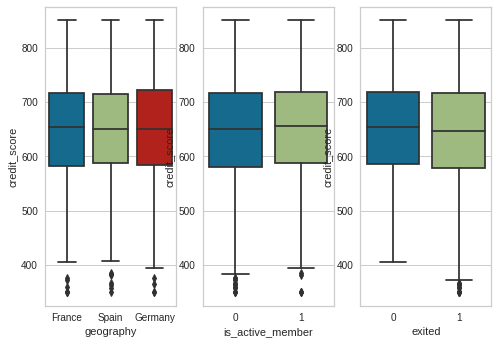

In [21]:
plt.subplot(1,3,1) 
sns.boxplot(x = 'geography', y = 'credit_score', data=df1)

plt.subplot(1,3,2)
sns.boxplot(x = 'is_active_member', y = 'credit_score', data=df1)

plt.subplot(1,3,3)
sns.boxplot(x = 'exited', y = 'credit_score', data=df1)

In [22]:
df_cat_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
num_of_products,10000.0,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
has_cr_card,10000.0,0.7055,0.455840,0.0,0.0,1.0,1.0,1.0
is_active_member,10000.0,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0
exited,10000.0,0.2037,0.402769,0.0,0.0,0.0,0.0,1.0


# 5.0 Feature Engineering 

In [23]:
df2 = df1.copy()

## 5.1 Hypotheses Mental Map

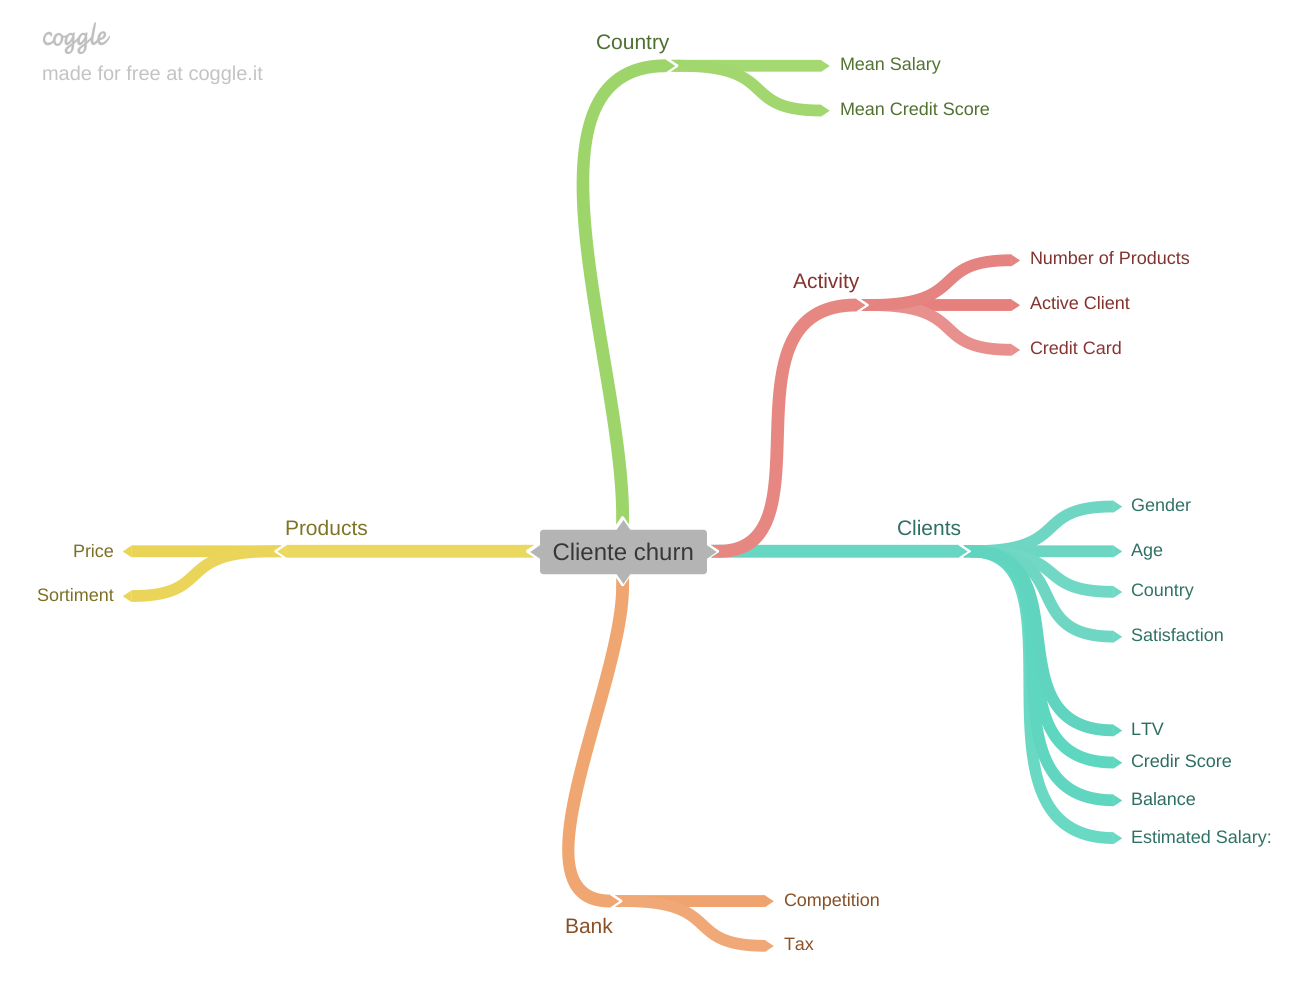

In [24]:
Image('../img/Cliente_churn.png')

## 5.1 Hypotheses

### 5.1.1 Client Hypotheses 

1. Cliente com idade abaixo de 32 anos sao 25% mais em Churn.
2. Clientes com salario abaixo de 1000 Churn sao 50% mais em Churn.
3. Clientes com Saldo maior que a media estão 30% menos presentes em churn.
4. Clientes com satisfação ruim estão 30% mais presentes em churn 
5. Clientes que moram na Franca tem churn 15% maior 


### 5.1.2 Country Hypotheses 

1. Clientes com salario menor que a media do pais tem Churn 10% maior. 
2. Clientes com Credit Score menor que a media do pais tem Churn 10% maior. 
3. Clientes com Saldo maior que a media do pais tem Churn é 20% menor. 

### 5.1.3 Activity Hypoteses 

1. Churn é 10% menor para clientes que possuen cartão. 
2. Churn é 30% menor para cliente ativos. 
3. Churn é 25% maior para clientes com apenas um produto comprado. 

### 5.1.4 Products Hypoteses 

1. Churn é 40% maior para taxa maior que a taxa media da competicao

## 5.2 Hypoteses List 

1. Cliente com idade abaixo de 32 anos sao 25% mais em Churn.
2. Clientes com salario abaixo de 1000 Churn sao 50% mais em Churn.
3. Clientes com Saldo maior que a media estão 30% menos presentes em churn.
4. Clientes que moram na Franca tem churn 15% maior 
5. Clientes com salario menor que a media do pais tem Churn 10% maior. 
6. Clientes com Credit Score menor que a media do pais tem Churn 10% maior. 
7. Clientes com Saldo maior que a media do pais tem Churn é 20% menor. 
8. Churn é 10% menor para clientes que possuen cartão. 
9. Churn é 30% menor para cliente ativos. 
10. Churn é 25% maior para clientes com apenas um produto comprado. 

## 5.3  Feature Engineering 

In [25]:
# creating geography median salary 
df2['geo_median_salary'] = df2.groupby('geography')['estimated_salary'].transform('median')

# creating geography median Credit Score 
df2['geo_median_cred'] = df2.groupby('geography')['credit_score'].transform('median')

# creating geography median balance
df2['geo_median_balc'] = df2.groupby('geography')['balance'].transform('median')

In [26]:
df2.head().T

,0,1,2,3,4
row_number,1,2,3,4,5
customer_id,15634602,15647311,15619304,15701354,15737888
surname,Hargrave,Hill,Onio,Boni,Mitchell
credit_score,619,608,502,699,850
geography,France,Spain,France,France,Spain
gender,Female,Female,Female,Female,Female
age,42,41,42,39,43
tenure,2,1,8,1,2
balance,0.0,83807.86,159660.8,0.0,125510.82
num_of_products,1,1,3,2,1


# 6.0 Variable Filtering

In [27]:
df3 = df2.copy()

## 6.1 Columns Select 

In [28]:
cols_drop = ['surname','customer_id']
df3 = df3.drop(cols_drop, axis=1)

In [29]:
df3.T

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
row_number,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
credit_score,619,608,502,699,850,645,822,376,501,684,...,714,597,726,644,800,771,516,709,772,792
geography,France,Spain,France,France,Spain,Spain,France,Germany,France,France,...,Germany,France,Spain,France,France,France,France,France,Germany,France
gender,Female,Female,Female,Female,Female,Male,Male,Female,Male,Male,...,Male,Female,Male,Male,Female,Male,Male,Female,Male,Female
age,42,41,42,39,43,44,50,29,44,27,...,33,53,36,28,29,39,35,36,42,28
tenure,2,1,8,1,2,8,7,4,4,2,...,3,4,2,7,2,5,10,7,3,4
balance,0.0,83807.86,159660.8,0.0,125510.82,113755.78,0.0,115046.74,142051.07,134603.88,...,35016.6,88381.21,0.0,155060.41,0.0,0.0,57369.61,0.0,75075.31,130142.79
num_of_products,1,1,3,2,1,2,2,4,2,1,...,1,1,1,1,2,2,1,1,2,1
has_cr_card,1,0,1,0,1,1,1,1,0,1,...,1,1,1,1,0,1,1,0,1,1
is_active_member,1,1,0,0,1,0,1,0,1,1,...,0,0,0,0,0,0,1,1,0,0


# 7.0 Exploratory Data Analysis 

In [30]:
df4 = df3.copy()
df_num_attributes = df4[['tenure','credit_score', 'age', 'balance', 'estimated_salary',
                         'geo_median_salary', 'geo_median_cred', 'geo_median_balc','num_of_products']]
df_cat_attributes = df4[['geography', 'gender', 'has_cr_card', 'is_active_member', 'exited',]]

## 7.1 Univariate

### 7.1.1 Response Attribute 

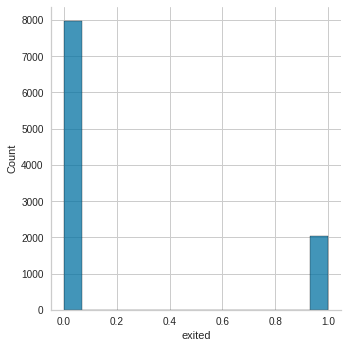

In [31]:
sns.displot(x = 'exited', data = df4);

### 7.1.2 Numerical Attributes 

In [32]:
df_num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
credit_score,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
estimated_salary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
geo_median_salary,10000.0,100162.652554,1339.072505,99132.31,99132.31,99132.310,102397.2200,102397.22
geo_median_cred,10000.0,652.002800,1.000046,651.00,651.00,653.000,653.0000,653.00
geo_median_balc,10000.0,76482.948678,25014.955033,61710.44,62153.50,62153.500,119703.1000,119703.10
num_of_products,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00


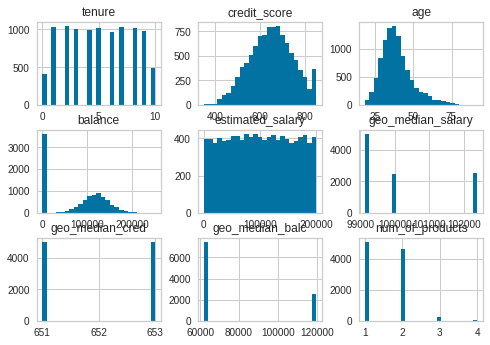

In [33]:
df_num_attributes.hist(bins=25);

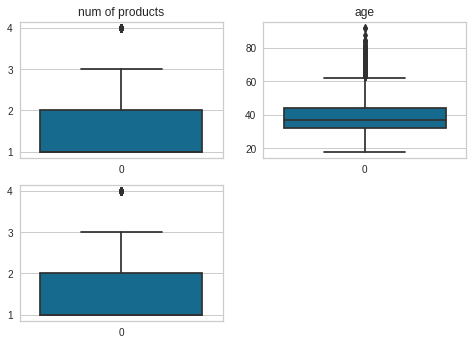

In [34]:
plt.subplot(2,2,1)
sns.boxplot(data = df_num_attributes['num_of_products']).set_title('num of products');

plt.subplot(2,2,2)
sns.boxplot(data = df_num_attributes['age']).set_title('age');

plt.subplot(2,2,3)
sns.boxplot(data = df_num_attributes['num_of_products']);

### 7.1.3 Categorical Attributes  

#### Geography


In [35]:
geo_precentage = df4['geography'].value_counts(normalize=True)*100

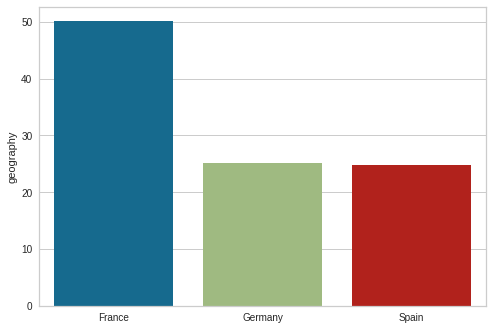

In [36]:
sns.barplot(x = geo_percentage.index , y = geo_percentage);

#### Credit Card 

In [37]:
cr_precentage = df4['has_cr_card'].value_counts(normalize=True)*100

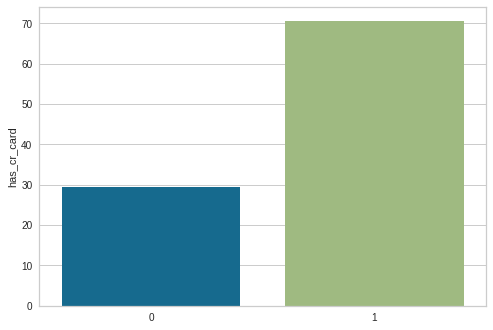

In [38]:
sns.barplot(x = cr_precentage.index , y = cr_precentage);

#### Activit  

In [39]:
actv_precentage = df4['is_active_member'].value_counts(normalize=True)*100

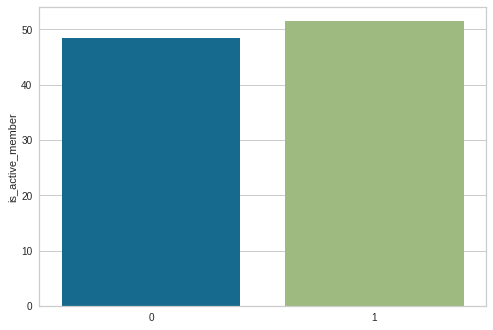

In [40]:
sns.barplot(x = actv_precentage.index , y = actv_precentage);

In [41]:
actv_precentage

1    51.51
0    48.49
Name: is_active_member, dtype: float64

- 50% dos clientes residem na franca, ja Alemanha e Franca possuem 25% dos clientes. 
- 70% dos clientes possuem cartao de credito. 
- 51% dos clientes realizaram alguma atividade nos ultimos 12 meses. 

## 7.2 Bivariate 

### **H1.** Cliente com idade abaixo de 38 anos sao 25% mais em Churn.
**FALSO** Clientes com idade acima de 38 anos estão 50% mais presentes em churn, mesmos sendo a menor populacao

In [42]:
df_age = df4[['age', 'exited','row_number']].copy()

In [43]:
df_age['above_below'] = df_age['age'].apply(lambda x : 'below' if x <= 38 else 'above')

In [44]:
aux5 = df_age[['age', 'exited','row_number']].groupby(['age', 'exited']).count().reset_index()

In [45]:
aux1 = df_age[df_age['exited']==1].groupby('age')['exited'].count().reset_index()

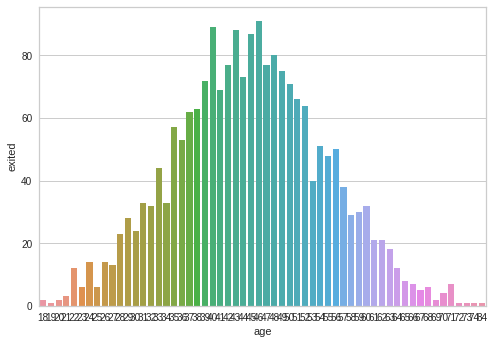

In [46]:
sns.barplot(x = 'age', y = 'exited',data = aux1);

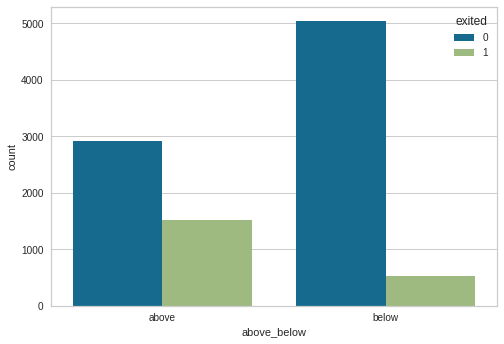

In [47]:
aux2 = df_age.groupby('exited')['above_below'].value_counts().to_frame(name='count').reset_index()
sns.countplot(x = 'above_below', hue = 'exited', data = df_age);

In [48]:
df_age.groupby('exited')['above_below'].value_counts(normalize = True)

exited  above_below
0       below          0.632802
        above          0.367198
1       above          0.742268
        below          0.257732
Name: above_below, dtype: float64

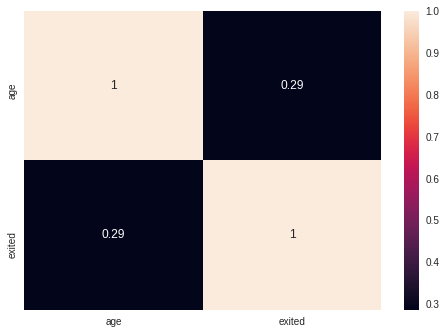

In [49]:
sns.heatmap(df_age[['age','exited']].corr(method = 'pearson'), annot = True);

- Como visto, 5564(55%) clientes possuem idade iferior ou igual a 38 anos e 4446(44%) possuem idade superior a 38 anos
- Aproximadamente 1512(75%) dos clientes em Churn tem idade maior que 38 anos e apenas 525(25%) tem idade inferior, assim sendo um diferença aprixomade de 50%. 
- Aproximadamente 2924(36%) dos clientes que não estão em Churn tem idade maior que 38 anos e apenas 5039(63%) tem idade inferior, assim sendo um diferença aprixomade de 50%. 

### **H3.** Clientes com Saldo maior que a media estão 30% menos presentes em churn.
**FALSE** Clientes com Saldo maior que a media estao 40% mais presentes em Churn que clientes com saldo menor. 

In [50]:
df_balance = df4[['balance', 'exited']].copy().reset_index()

In [51]:
df_balance['h_balance'] = df_balance['balance'].apply(lambda x : 'above' if x > df_balance['balance'].mean() 
                                                      else 'below' )

In [52]:
df_balance_ext = df_balance.groupby('exited')['h_balance'].value_counts(normalize = True).to_frame(name ='count').reset_index()

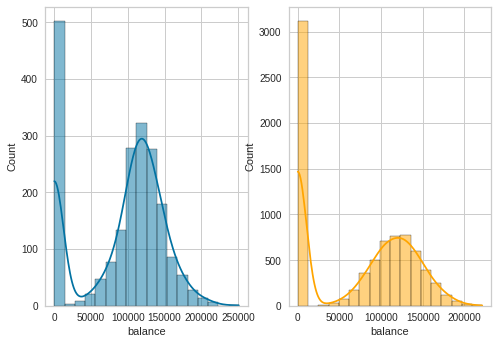

In [53]:
plt.subplot(1,2,1)
sns.histplot(x = 'balance', data = df_balance[df_balance['exited']==1],kde=True); 
plt.subplot(1,2,2)
sns.histplot(x = 'balance', data = df_balance[df_balance['exited']==0], color='orange',kde = True ); 


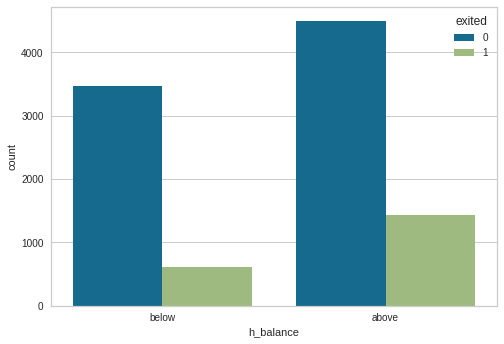

In [54]:
sns.countplot(x = 'h_balance', hue = 'exited', data = df_balance);

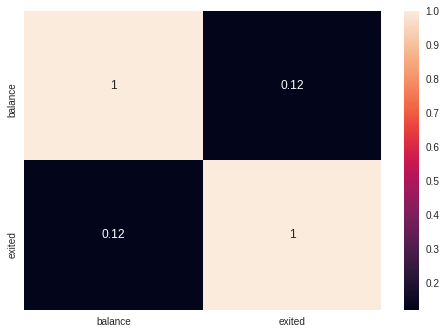

In [55]:
sns.heatmap(df_balance[['balance','exited']].corr(method = 'pearson'), annot = True);

- Como observado no Churn, cerca de 1426(70%) clientes possuem saldo maior que a media, quanto apenas 611(30%) tem saldo menor. 
- Como observado nos clientes que nao estao em Churn, clientes que tem saldo maior que a media mesmo sendo maior numero em Churn tambem é a maiora nem não Churn sendo 4493(55%) , quanto os com saldo menor sao 3470(45%) 

### H4. Franca tem churn 15% maior que outros paises. 
**FALSE** A taxa de Churn da Franca é aproximadamente 15% menor que a da Alemanha. 

In [56]:
df_geo = df4[['exited', 'geography', 'row_number']]

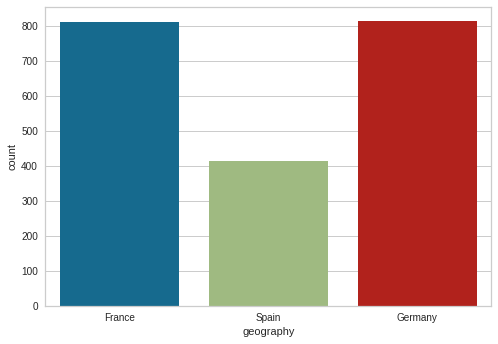

In [57]:
sns.countplot(x = 'geography', data = df_geo[df_geo['exited']==1]);

In [58]:
df_geo.groupby(['geography'])['exited'].value_counts(normalize = True ).to_frame(name = 'clients').reset_index()

,geography,exited,clients
0,France,0,0.838452
1,France,1,0.161548
2,Germany,0,0.675568
3,Germany,1,0.324432
4,Spain,0,0.833266
5,Spain,1,0.166734


In [59]:
df_geo.groupby(['exited'])['geography'].value_counts(normalize = True ).to_frame(name = 'clients').reset_index()

,exited,geography,clients
0,0,France,0.527942
1,0,Spain,0.259199
2,0,Germany,0.212859
3,1,Germany,0.399607
4,1,France,0.397644
5,1,Spain,0.202749


- Ao analisar clientes de cada pais foi visto que a taxa de churn de clientes residentes na Franca é de 16%, semelhante a Espanha, ja Alemanha possui uma taxa de 36% considerando o tamanho das populacoes. 
- Clientes em churn foi visto que 39% sao da Alemanha e Franca, 20% sao da Espanha. 
- Clientes que nao estao em chur, 52% sao franceses,25% espanhois e 21% alemaes.  

### H5. Clientes com salario menor que a media do pais tem Churn 10% maior. 
**FALSE** Clintes com Salario acima da mediana do pais estao 1% mais presentes em Churn que clientes que possuem salario menor que a mediana.

In [60]:
df_geo_salary = df4[['exited', 'geo_median_salary', 'estimated_salary']].copy()

In [61]:
df_geo_salary['above_below'] = df_geo_salary.apply(lambda x : 'above' if x['estimated_salary'] > x['geo_median_salary']
                                                   else 'below', axis = 1 )

In [62]:
# Porcentagem de clienetes acima e abaixo da media em Churn
aux1 = (df_geo_salary.groupby('exited' )['above_below'].value_counts(normalize = True)*100).to_frame(name = 'clients').reset_index()
aux1

,exited,above_below,clients
0,0,below,50.269999
1,0,above,49.730001
2,1,above,51.006382
3,1,below,48.993618


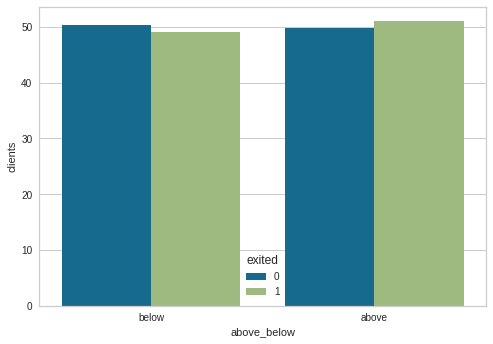

In [63]:
sns.barplot(x = 'above_below', y = 'clients', hue = 'exited', data = aux1);

In [64]:
# Porcentagem de clientes em churn e nao Churn que estao abaixo da media
df_geo_salary.groupby('above_below' )['exited'].value_counts(normalize = True).to_frame(name = 'clients')

clients
above_below exited          
above       0       0.792158
            1       0.207842
below       0       0.800440
            1       0.199560

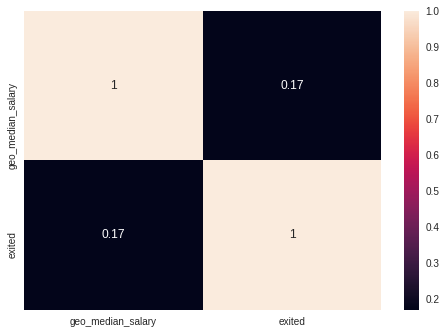

In [65]:
sns.heatmap(df_geo_salary[['geo_median_salary','exited']].corr(method = 'pearson'), annot = True);

### H6. Clientes com Credit Score menor que a media do pais tem Churn 10% maior. 
**TRUE** O Numero de clientes em Churn com credit score menor que a media de seu pais é 7% menor que clientes com credt score maior. 

In [66]:
df_geo_cred = df4[['exited', 'geo_median_cred', 'credit_score']].copy()

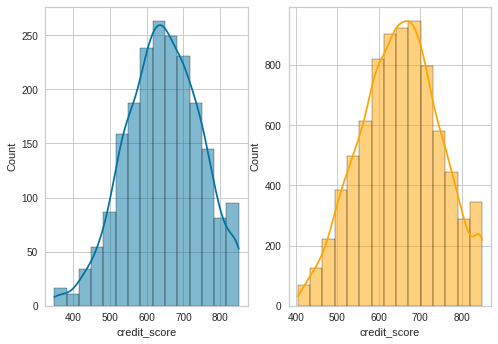

In [67]:
plt.subplot(1,2,1)
sns.histplot(x = 'credit_score', data = df_geo_cred[df_geo_cred['exited']==1],kde=True, bins = 15); 
plt.subplot(1,2,2)
sns.histplot(x = 'credit_score', data = df_geo_cred[df_geo_cred['exited']==0],kde=True, color = 'orange', bins=15); 

In [68]:
df_geo_cred['above_below'] = df_geo_cred.apply(lambda x : 'above' if x['credit_score'] > x['geo_median_cred']
                                                   else 'below', axis = 1 )

In [69]:
aux = (df_geo_cred.groupby('exited')['above_below'].value_counts()).to_frame(name = 'clients').reset_index()
aux

,exited,above_below,clients
0,0,above,4016
1,0,below,3947
2,1,below,1082
3,1,above,955


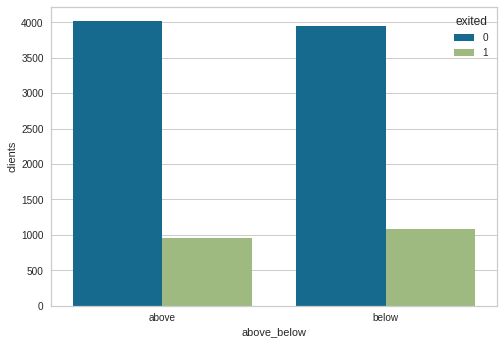

In [70]:
sns.barplot(x = 'above_below', y = 'clients', hue = 'exited', data = aux);

In [71]:
(df_geo_cred.groupby('above_below')['exited'].value_counts(normalize = True)*100).to_frame(name = 'clients').reset_index()

,above_below,exited,clients
0,above,0,80.788574
1,above,1,19.211426
2,below,0,78.484788
3,below,1,21.515212


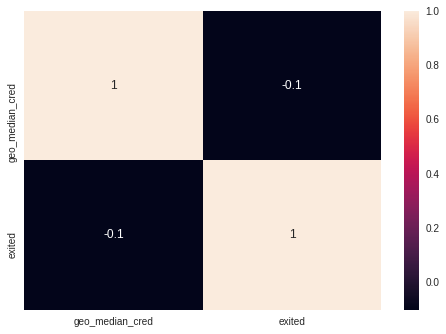

In [72]:
sns.heatmap(df_geo_cred[['geo_median_cred', 'exited']].corr(method ='pearson'), annot = True);

- Ao analisar o numero de clientes em churn foi encontrado que aproximadamente 53% desse numero e de clientes com a Credit Score menor que a mediana de seu pais e 46% maior. 
- Cerca de 49% dos clientes possuem Credit Score maior que a media do pais. 

### H7. Clientes com Saldo maior que a media do pais tem Churn  20% menor. 
**FALSE** Clientes com saldo maior que a media de seu pais são aproximadamente 5% mais presentes em Churn, se comparado com clientes com saldo menor. 

In [73]:
df_geo_balance = df4[['exited', 'geo_median_balc', 'balance']].copy()

In [74]:
df_geo_balance['below_above'] = df_geo_balance.apply(lambda x: 'above' if x['balance'] > x['geo_median_balc']
                                                    else 'below', axis = 1)

In [75]:
aux = df_geo_balance.groupby('exited')['below_above'].value_counts(normalize = True).to_frame(name = 'clients').reset_index()
aux

,exited,below_above,clients
0,0,below,0.506844
1,0,above,0.493156
2,1,above,0.526264
3,1,below,0.473736


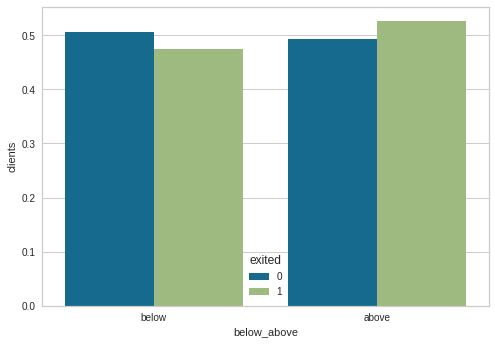

In [76]:
sns.barplot(x = 'below_above', y ='clients', hue = 'exited', data = aux);

In [77]:
aux1 = df_geo_balance.groupby('below_above')['exited'].value_counts(normalize = True).to_frame(name = 'clients').reset_index()
aux1

,below_above,exited,clients
0,above,0,0.785557
1,above,1,0.214443
2,below,0,0.807039
3,below,1,0.192961


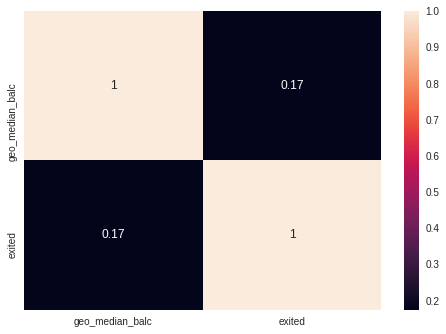

In [78]:
sns.heatmap(df_geo_balance[['geo_median_balc', 'exited']].corr(method ='pearson'), annot = True);

- Como analisado a populacao d clientes em churn, 52% dos clientes tem seu saldo maior que a media de seu pais, logo 47% tem abaixo. 
- Analisando a populacao de clientes com saldo acima da media, a taxa de Churn é aproximadamente 21%, 2% a mais que a taxa de Churn da populacao com saldo menor.

### H8. Churn é 10% menor para clientes que possuen cartão. 

In [79]:
df_cred = df4[['has_cr_card', 'exited']].copy()

In [80]:
df_cred['has_cr_card'].value_counts(normalize = True)

1    0.7055
0    0.2945
Name: has_cr_card, dtype: float64

In [81]:
aux = df_cred.groupby('exited')['has_cr_card'].value_counts(normalize = True).to_frame(name = 'clients').reset_index()
aux

,exited,has_cr_card,clients
0,0,1,0.707146
1,0,0,0.292854
2,1,1,0.699067
3,1,0,0.300933


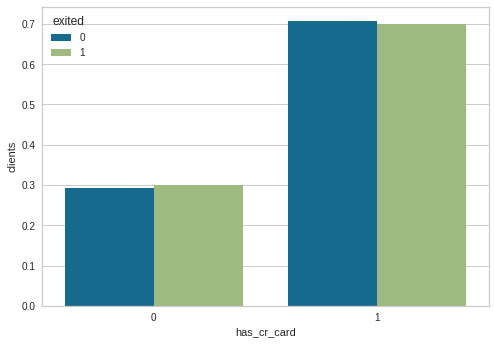

In [82]:
sns.barplot(x = 'has_cr_card', y = 'clients', hue = 'exited', data = aux);

In [83]:
aux1 = df_cred.groupby('has_cr_card')['exited'].value_counts(normalize = True).to_frame(name = 'clients').reset_index()
aux1

,has_cr_card,exited,clients
0,0,0,0.791851
1,0,1,0.208149
2,1,0,0.798157
3,1,1,0.201843


### H9. Churn é 30% menor para cliente ativos. 
**TRUE** Clientes não ativos estão mais presentes em Churn, embora não tenha um diferença de 30%, a porcentagem de 63% é consideravel para os parametros da Hipotese. 

In [84]:
df_active = df4[['exited', 'is_active_member']].copy()

In [85]:
# Porcentagem de clientes ativos e nao ativos na populacao
df_active['is_active_member'].value_counts(normalize = True)*100

1    51.51
0    48.49
Name: is_active_member, dtype: float64

In [86]:
aux = (df_active.groupby('exited')['is_active_member'].value_counts(normalize = True)*100).to_frame(name = 'clients').reset_index()
aux

,exited,is_active_member,clients
0,0,1,55.456486
1,0,0,44.543514
2,1,0,63.917526
3,1,1,36.082474


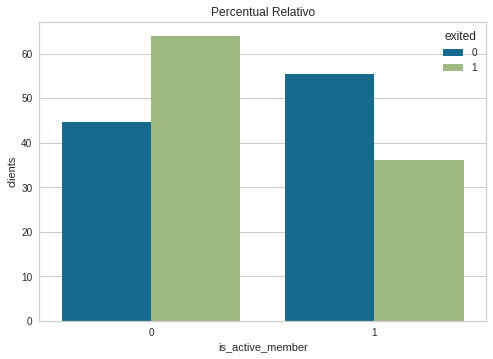

In [87]:
sns.barplot(x = 'is_active_member', y = 'clients', hue = 'exited', data = aux).\
set_title('Percentual Relativo');

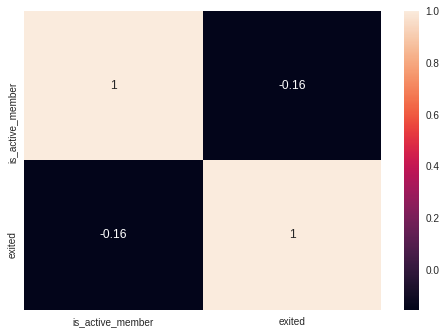

In [88]:
sns.heatmap(df_active[['is_active_member', 'exited']].corr(method ='pearson'), annot = True);

- Aproximadamente 51% dos clientes são ativos. 49% não são ativos. 
- Analisando os clientes em Churn, aproximadamente 64% são clientes não ativos, 36% são ativos
- Para os clientes que não estão em Churn, 55% deles são ativos e 45% não estão mais ativos. 

### H10. Churn é 25% maior para clientes com apenas um produto comprado. 
**TRUE** Clientes com apenas um produto comprado podem ser ate 60% mais presentes em Churn que clientes que compraram mais produtos. 

In [89]:
df_product = df4[['exited', 'num_of_products']].copy()

In [90]:
df_product['num_of_products'].value_counts(normalize = True)

1    0.5084
2    0.4590
3    0.0266
4    0.0060
Name: num_of_products, dtype: float64

In [91]:
aux = df_product['num_of_products'].value_counts().to_frame(name = 'client').reset_index()
aux

,index,client
0,1,5084
1,2,4590
2,3,266
3,4,60


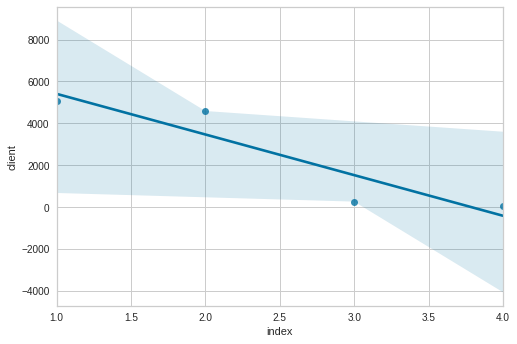

In [92]:
sns.regplot(x = 'index', y = 'client', data = aux);

In [93]:
aux1 = (df_product.groupby('exited')['num_of_products'].value_counts(normalize = True)*100).to_frame(name = 'client').reset_index()
aux1

,exited,num_of_products,client
0,0,2,53.271380
1,0,1,46.150948
2,0,3,0.577672
3,1,1,69.170349
4,1,2,17.083947
5,1,3,10.800196
6,1,4,2.945508


In [94]:
aux2 = (df_product.groupby('num_of_products')['exited'].value_counts(normalize = True)*100).to_frame(name = 'client').reset_index()
aux2

,num_of_products,exited,client
0,1,0,72.285602
1,1,1,27.714398
2,2,0,92.418301
3,2,1,7.581699
4,3,1,82.706767
5,3,0,17.293233
6,4,1,100.000000


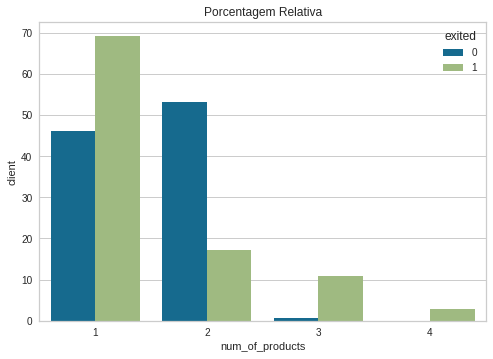

In [95]:
sns.barplot(x = 'num_of_products', y = 'client', hue = 'exited', data = aux1).set_title('Porcentagem Relativa');

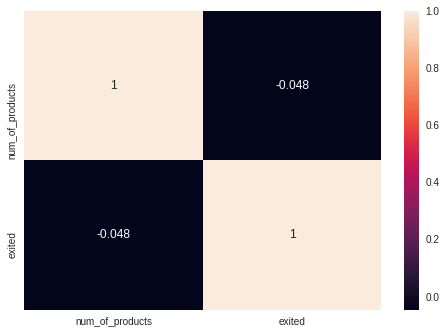

In [96]:
sns.heatmap(df_product[['num_of_products', 'exited']].corr(method ='pearson'), annot = True);

- 50% dos clientes possui apenas um produto. 
- 100% dos clientes com 4 produtos comprados estao em Churn
- Analisando os Clientes em Churn, aproximadamente 70% deles possuem apenas um produto comprado, enquanto 17% possuem 2 produtos, 10% possuem 3 e apenas 2% possuem 4
- Analisando clientes que nao estao em Churn 54% deles possuem 2 produtos, sendo assim a maioria. 
- Considerando todos os clientes com apenas 1 produtos 70% nao estao em Churn
- Considerando todos os clientes com apenas 2 produtos 90% nao estao em Churn
- Considerando todos os clientes com apenas 3 produtos 17% nao estao em Churn

        Hipotese |    Conclusao   | Relevancia 
        --------- -----------  ---------
    H1 -Idade	       False 	Alta
    H3 -Saldo	       False 	alto
    H4 -pais	       False 	Media
    H5 -geo Salario    False 	media
    H6 -geo cred	   True	    baixa
    H7 -geo Saldo	   False 	media
    H8 -Cartao	       True	    baixa
    H9 -Ativo	       True	    media
    H10 -produto	   True	    alto

## 7.3 Multivariate

### 7.3.1 Numerical Attributes

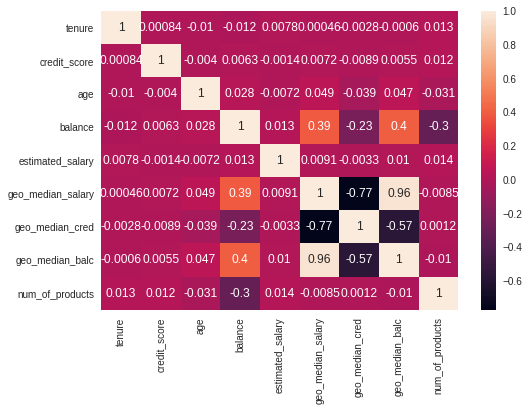

In [97]:
corr = df_num_attributes.corr(method = 'pearson')
sns.heatmap(corr , annot = True);
plt.yticks(rotation='horizontal');

### 7.3.1 Categorical Attributes

In [98]:
#apply cramers v correlation to all categorical attributes  

x_columns = df_cat_attributes.columns
y_columns = df_cat_attributes.columns

crame = {}

for x_col in x_columns:
    corr_list = []
    for y_col in y_columns:
        corr_list.append(cramer_v(df_cat_attributes.loc[:,x_col], df_cat_attributes.loc[:,y_col]))
        
    crame[x_col] = corr_list
    

In [99]:
# create df with cramers v correlation
df_cramer_corr = pd.DataFrame(crame)
df_cramer_corr = df_cramer_corr.set_index(x_columns)

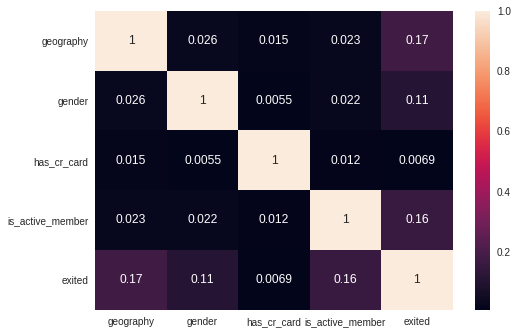

In [100]:
sns.heatmap(df_cramer_corr, annot = True);

# 8.0 Data Preparation

In [161]:
df5 = df4.copy()

## 8.1 Normalization 

### 8.1.1 Credit Score

In [162]:
df5[['credit_score']].head(5)

,credit_score
0,619
1,608
2,502
3,699
4,850


In [163]:
scaler_credit = StandardScaler()
df5['credit_score'] = scaler_credit.fit_transform(df5[['credit_score']].values)
pickle.dump(scaler_credit, open('../parameter/standard_scaler_credit.pkl', 'wb'))
    

In [164]:
df5[['credit_score']].head(5)

,credit_score
0,-0.326221
1,-0.440036
2,-1.536794
3,0.501521
4,2.063884


## 8.2 Rescaling 

In [165]:
df5[['tenure', 'age', 'estimated_salary', 'geo_median_salary',
     'geo_median_cred', 'geo_median_balc', 'num_of_products']].head(5)

,tenure,age,estimated_salary,geo_median_salary,geo_median_cred,geo_median_balc,num_of_products
0,2,42,101348.88,99132.31,653.0,62153.50,1
1,1,41,112542.58,99984.86,651.0,61710.44,1
2,8,42,113931.57,99132.31,653.0,62153.50,3
3,1,39,93826.63,99132.31,653.0,62153.50,2
4,2,43,79084.10,99984.86,651.0,61710.44,1


In [166]:
# min max scaler 
min_max_scaler = MinMaxScaler()

# tenure 
df5['tenure'] = min_max_scaler.fit_transform( df5[['tenure']].values)
pickle.dump(min_max_scaler, open('../parameter/min_max_scaler_tenure.pkl', 'wb'))

#age 
df5['age'] = min_max_scaler.fit_transform( df5[['age']].values)
pickle.dump(min_max_scaler, open('../parameter/min_max_scaler_age.pkl', 'wb'))

# estimated salary
df5['estimated_salary'] = min_max_scaler.fit_transform( df5[['estimated_salary']].values)
pickle.dump(min_max_scaler, open('../parameter/min_max_scaler_salary.pkl', 'wb'))

# geo_median_salary
df5['geo_median_salary'] = min_max_scaler.fit_transform( df5[['geo_median_salary']].values)
pickle.dump(min_max_scaler, open('../parameter/min_max_scaler_geo_salary.pkl', 'wb'))

# geo_median_cred
df5['geo_median_cred'] = min_max_scaler.fit_transform( df5[['geo_median_cred']].values)
pickle.dump(min_max_scaler, open('../parameter/min_max_scaler_geo_credit.pkl', 'wb'))

# geo_median_balc
df5['geo_median_balc'] = min_max_scaler.fit_transform( df5[['geo_median_balc']].values)
pickle.dump(min_max_scaler, open('../parameter/min_max_scaler_geo_balance.pkl', 'wb'))

#balance
df5['balance'] = min_max_scaler.fit_transform(df5[['balance']].values)
pickle.dump(min_max_scaler, open('../parameter/min_max_scaler_balance.pkl', 'wb'))

In [167]:
df5[['tenure', 'age', 'estimated_salary', 'geo_median_salary',
     'geo_median_cred', 'geo_median_balc', 'num_of_products', 'balance']].head(5)

,tenure,age,estimated_salary,geo_median_salary,geo_median_cred,geo_median_balc,num_of_products,balance
0,0.2,0.324324,0.506735,0.000000,1.0,0.00764,1,0.000000
1,0.1,0.310811,0.562709,0.261125,0.0,0.00000,1,0.334031
2,0.8,0.324324,0.569654,0.000000,1.0,0.00764,3,0.636357
3,0.1,0.283784,0.469120,0.000000,1.0,0.00764,2,0.000000
4,0.2,0.337838,0.395400,0.261125,0.0,0.00000,1,0.500246


In [168]:
# num_of_products
df5['num_of_products'] = min_max_scaler.fit_transform( df5[['num_of_products']].values)
pickle.dump(min_max_scaler, open('../parameter/min_max_scaler_products.pkl', 'wb'))

In [169]:
df5[['tenure', 'age', 'estimated_salary', 'geo_median_salary',
     'geo_median_cred', 'geo_median_balc', 'num_of_products', 'balance']].head(5)

,tenure,age,estimated_salary,geo_median_salary,geo_median_cred,geo_median_balc,num_of_products,balance
0,0.2,0.324324,0.506735,0.000000,1.0,0.00764,0.000000,0.000000
1,0.1,0.310811,0.562709,0.261125,0.0,0.00000,0.000000,0.334031
2,0.8,0.324324,0.569654,0.000000,1.0,0.00764,0.666667,0.636357
3,0.1,0.283784,0.469120,0.000000,1.0,0.00764,0.333333,0.000000
4,0.2,0.337838,0.395400,0.261125,0.0,0.00000,0.000000,0.500246


## 8.3 Transformation 

### 8.3.1 Enconding 

In [170]:
df5[['geography', 'gender']].head(10)

,geography,gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
4,Spain,Female
5,Spain,Male
6,France,Male
7,Germany,Female
8,France,Male
9,France,Male


In [171]:
# Label Enconding geography
label_enc = LabelEncoder()
df5['geography'] = label_enc.fit_transform(df5['geography'])
pickle.dump(label_enc, open('../parameter/encoding_label_geo.pkl', 'wb'))

# Label Enconding gender
df5['gender'] = label_enc.fit_transform(df5['gender'])
pickle.dump(label_enc, open('../parameter/encoding_label_gender.pkl', 'wb'))

In [172]:
df5[['geography', 'gender']].head(10)

,geography,gender
0,0,0
1,2,0
2,0,0
3,0,0
4,2,0
5,2,1
6,0,1
7,1,0
8,0,1
9,0,1


# 9.0 Feature Selection 

In [113]:
df6 = df5.copy()
df6.drop(['row_number', 'geo_median_salary'], axis = 1 , inplace= True)

## 9.1 Data Balancing 

A proporcao de clientes em churn é 20% enquanto para clientes que não estão em churn é 80%, logo os modelos terão mais exemplos de clientes que não estão em churn. 

Desse modo, o algoritmo pode aprender melhor como prever pessoas que não estao em churn, o que não é o objetivo. Para prevenir que isso aconteça, dos dados serão balanceados com um algoritimo -Smote Tomek- que usa oversampling. 

In [114]:
x = df6.drop('exited', axis = 1 ) 
y  = df6['exited']


x_train_imb,x_test, y_train_imb, y_test = train_test_split(x, y, test_size= 0.4, random_state=42, stratify=y)

In [115]:
ressempler = SMOTETomek(random_state= 123, n_jobs=-1)
x_train, y_train = ressempler.fit_resample(x_train_imb, y_train_imb)

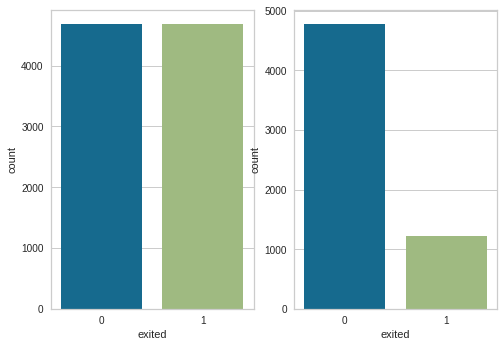

In [116]:
plt.subplot(1,2,1)
sns.countplot(x = y_train)

plt.subplot(1,2,2)
sns.countplot(x = y_train_imb);

## 9.2 Boruta as Feature Selector 

In [117]:
random_flr = RandomForestClassifier(n_jobs=-1)
boruta  = BorutaPy(random_flr, n_estimators= 'auto', verbose=2, random_state=42).fit(x_train.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	6


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	6


In [118]:
cols_selected = boruta.support_.tolist()

In [119]:
x_train.iloc[:, cols_selected].columns.tolist()

['credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'estimated_salary']

In [120]:
cols_select = ['credit_score','age', 'tenure', 'balance', 'num_of_products', 'estimated_salary', 
               'geography', 'is_active_member']

# 10.0 Modeling 

In [121]:
x_train = x_train[cols_select].copy()

x_test = x_test[cols_select].copy()

x_train_imb = x_train_imb[cols_select].copy()

## 10.1 Random Forest  

### 10.1.1 Balanced 

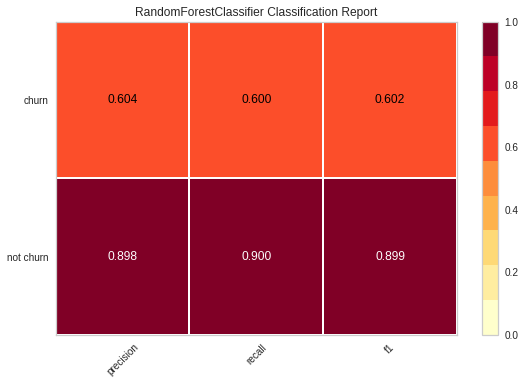

In [122]:
# model
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

# prediction - test 
visualizer = ClassificationReport(rf, classes=['not churn', 'churn'],  support=False)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.finalize()


In [123]:
rf_cv = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rf_score = performance(rf_cv, x_train, y_train)
rf_score

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,1.83252,0.126082,0.901174,0.907049,0.894266,0.896368


### 10.1.2 Imbalanced 

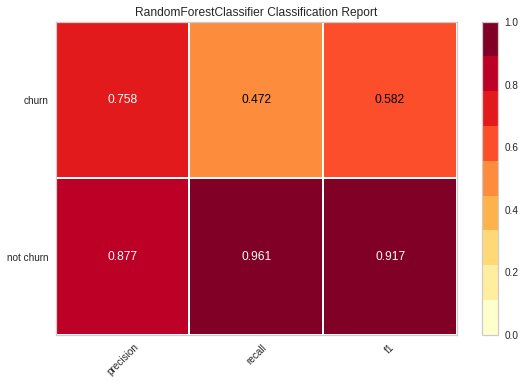

In [124]:
# model
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

# prediction - test 
visualizer = ClassificationReport(rf, classes=['not churn', 'churn'],  support=False)
visualizer.fit(x_train_imb, y_train_imb)
visualizer.score(x_test, y_test)
visualizer.finalize()

## 10.2 XGB

### 10.2.1 Balanced

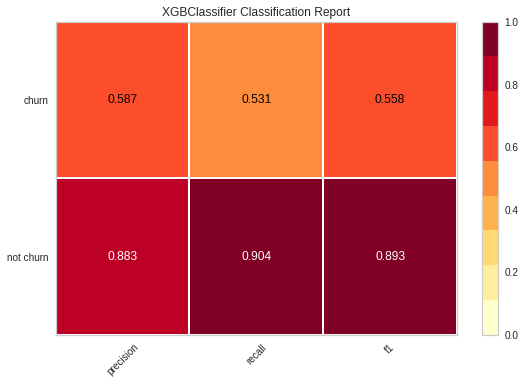

In [125]:
xgb = XGBClassifier(n_estimators=500, n_jobs=-1, random_state=42, eval_metric = 'logloss', use_label_encoder=False)
# prediction - test 
visualizer = ClassificationReport(xgb, classes=['not churn', 'churn'],  support=False)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.finalize()


In [126]:
xgb_cv = XGBClassifier(n_estimators=500, n_jobs=-1, random_state=42, eval_metric = 'logloss', use_label_encoder=False)
xgb_score = performance(xgb_cv, x_train, y_train)
xgb_score

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,1.202342,0.008334,0.893917,0.912725,0.869881,0.878665


### 10.2.2 Imbalanced

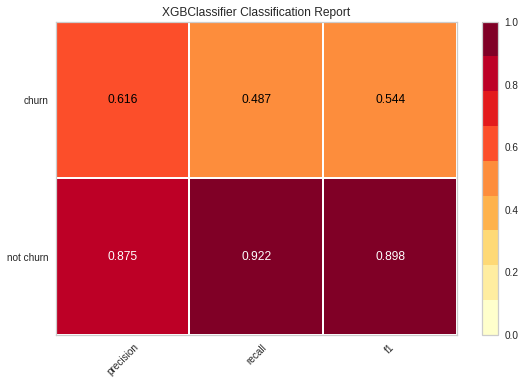

In [127]:
xgb = XGBClassifier(n_estimators=500, n_jobs=-1, random_state=42, eval_metric = 'logloss', use_label_encoder=False)
# prediction - test 
visualizer = ClassificationReport(xgb, classes=['not churn', 'churn'],  support=False)
visualizer.fit(x_train_imb, y_train_imb)
visualizer.score(x_test, y_test)
visualizer.finalize()


## 10.3 QDA

### 10.3.1 Balanced

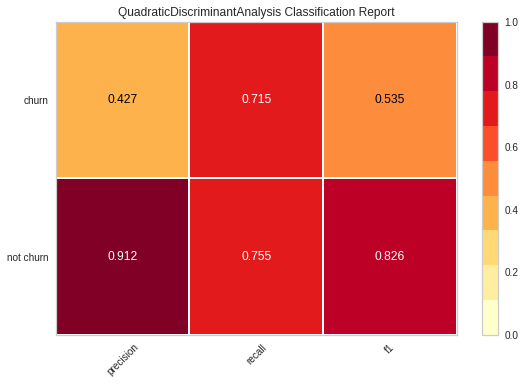

In [128]:
qda = QuadraticDiscriminantAnalysis()
# prediction - test 
visualizer = ClassificationReport(qda, classes=['not churn', 'churn'],  support=False)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.finalize()

In [129]:
qda_cv = QuadraticDiscriminantAnalysis()
qda_score = performance(qda_cv, x_train, y_train)
qda_score

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,0.00591,0.002907,0.730309,0.746556,0.69754,0.721136


### 10.3.2 Imbalanced

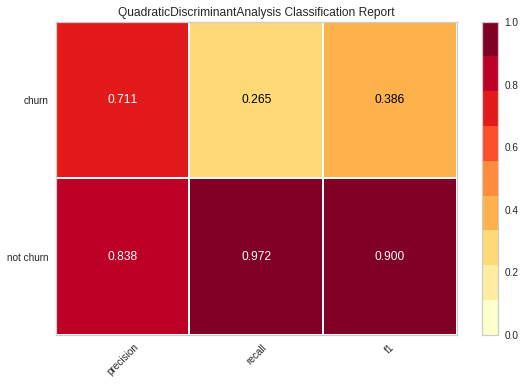

In [130]:
qda = QuadraticDiscriminantAnalysis()
# prediction - test 
visualizer = ClassificationReport(qda, classes=['not churn', 'churn'],  support=False)
visualizer.fit(x_train_imb, y_train_imb)
visualizer.score(x_test, y_test)
visualizer.finalize()

## 10.4 Cross-Validation

In [131]:
model_score_cv = pd.concat([qda_score, xgb_score, rf_score])
model_score_cv

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,0.005910,0.002907,0.730309,0.746556,0.697540,0.721136
0,1.202342,0.008334,0.893917,0.912725,0.869881,0.878665
0,1.832520,0.126082,0.901174,0.907049,0.894266,0.896368


# 11.0 Hyperparameter Fine Tuning

## 11.1 Random Search  

In [132]:
param = {'n_estimators':[100,300,500,700,900,1100],
         'max_depth':[4,8,12,15,20,28,35,40, None],
        'min_samples_split':[2,5,10],
        'min_samples_leaf':[1,2,5,10]}

### 11.1.1 Balanced data

In [133]:
#rf = RandomForestClassifier(n_jobs=-1, random_state=42)

In [134]:
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param, scoring='f1', n_iter=50, cv=10,
                               #verbose=2, n_jobs=-1, random_state=42)

In [135]:
# search tuning 
## rf_random.fit(x_train, y_train)

In [136]:
# rf_random.best_estimator_

In [137]:
# rf_tuned = rf_random.best_estimator_
# rf_tuned

In [138]:
# with open('../model/model_rf_tuned.pkl', 'wb') as f:
    #pickle.dump(rf_tuned, f)

### 11.1.2 Imbalanced data

In [139]:
# rf = RandomForestClassifier(n_jobs=-1, random_state=42)

In [140]:
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param, scoring='f1', n_iter=50, cv=10,
                               # verbose=2, n_jobs=-1, random_state=42)

In [141]:
# search tuning 
# rf_random.fit(x_train_imb, y_train_imb)

In [142]:
#rf_random.best_estimator_

In [143]:
#rf_imb_tuned = rf_random.best_estimator_
#rf_imb_tuned

In [144]:
#with open('../model/model_rf_imb_tuned.pkl', 'wb') as f:
    #pickle.dump(rf_imb_tuned, f)

## 11.2 Final Model 

### 11.2.1 Balanced test

In [145]:
with open('../model/model_rf_tuned.pkl', 'rb') as f:
    rf_tuned = pickle.load(f)

In [146]:
rf_performance_test = performance_test(rf_tuned, x_test, y_test)
rf_performance_test

,precision,recall,f1_score,roc_auc
0,0.608426,0.602454,0.605425,0.751619


- O modelo tem uma precisao de 60% para rotulas os clientes como Churn.
- O modelo conseue detecrar 60% dos clientes em Churn.

### 11.2.2 Imbalanced test

In [147]:
with open('../model/model_rf_imb_tuned.pkl', 'rb') as f:
    rf_imb_tuned = pickle.load(f)

In [148]:
rf_imb_performance_test = performance_test(rf_imb_tuned, x_test, y_test)
rf_imb_performance_test

,precision,recall,f1_score,roc_auc
0,0.762846,0.47362,0.584406,0.717972


# 12.0 Model and Business 

In [149]:
# predict probabilities 
proba = rf_tuned.predict_proba(x_test)
y_hat = pd.DataFrame(rf_tuned.predict(x_test)).rename(columns={0:'prediction'})
y_proba = pd.DataFrame(proba).rename(columns={1:'proba'})

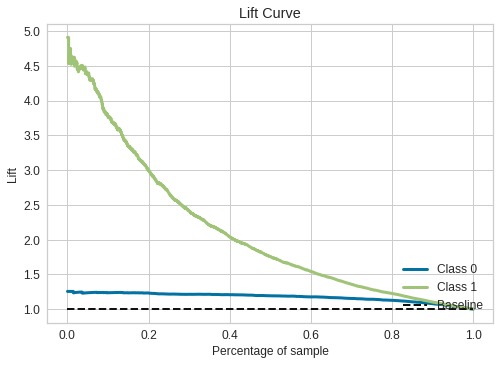

In [150]:
skplt.metrics.plot_lift_curve(y_test, proba);

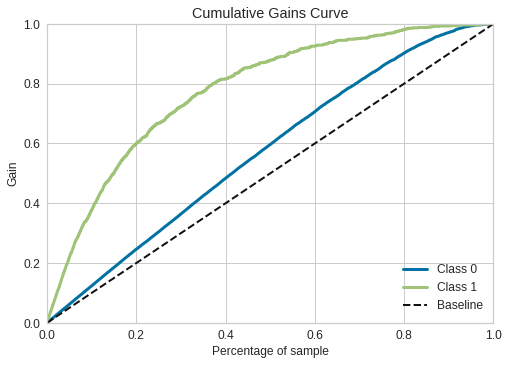

In [151]:
skplt.metrics.plot_cumulative_gain(y_test, proba);

In [152]:
balance = df1.iloc[x_test.index][['estimated_salary']].copy()
df_exit_balance = pd.concat((balance, y_test), axis = 1)
df_exit_balance.reset_index(drop = True, inplace=True)

In [153]:
prediction = pd.concat((df_exit_balance, y_hat,y_proba), axis = 1 )
prediction.drop([0], axis=1, inplace=True)


In [154]:
prediction.sort_values(by = 'proba', ascending=False,inplace = True)
aux = prediction.head(100)

In [155]:
prediction['prediction'].value_counts()

0    3193
1     807
Name: prediction, dtype: int64

In [156]:
807/len(prediction)

0.20175

# Class Production 

In [78]:
import pandas as pd 
import pickle
import numpy as np
import inflection
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder

class ChurnTopBank(object):
    def __init__(self):
        self.home_path = '/home/giovane/pythonProject/bank_churn'
        self.standard_scaler_credit = pickle.load(open(self.home_path + '/parameter/standard_scaler_credit.pkl', 'rb'))
        self.min_max_scaler_tenure =  pickle.load(open(self.home_path + '/parameter/min_max_scaler_tenure.pkl', 'rb'))
        self.min_max_scaler_age =     pickle.load(open(self.home_path + '/parameter/min_max_scaler_age.pkl', 'rb'))
        self.min_max_scaler_salary =  pickle.load(open(self.home_path + '/parameter/min_max_scaler_salary.pkl', 'rb'))
        self.min_max_scaler_geo_salary = pickle.load(open(self.home_path + '/parameter/min_max_scaler_geo_salary.pkl', 'rb'))
        self.min_max_scaler_geo_credit = pickle.load(open(self.home_path + '/parameter/min_max_scaler_geo_credit.pkl', 'rb'))
        self.min_max_scaler_geo_balance = pickle.load(open(self.home_path + '/parameter/min_max_scaler_geo_balance.pkl', 'rb'))
        self.min_max_scaler_balance = pickle.load(open(self.home_path + '/parameter/min_max_scaler_balance.pkl', 'rb'))
        self.encoding_label_geo = pickle.load(open(self.home_path + '/parameter/encoding_label_geo.pkl', 'rb'))
        self.encoding_label_gender = pickle.load(open(self.home_path + '/parameter/encoding_label_gender.pkl', 'rb'))
        
    def data_cleaning(self, df_churn):
        
        cols_old = df_churn.columns
        snake_case = lambda x : inflection.underscore(x)
        cols_new = list(map(snake_case, cols_old))

        #renomeando colunas
        df_churn.columns = cols_new
        
        return df_churn
        
    def feature_engineering(self, df_churn):
        
        # creating geography median salary 
        df_churn['geo_median_salary'] = df_churn.groupby('geography')['estimated_salary'].transform('median')

        # creating geography median Credit Score 
        df_churn['geo_median_cred'] = df_churn.groupby('geography')['credit_score'].transform('median')

        # creating geography median balance
        df_churn['geo_median_balc'] = df_churn.groupby('geography')['balance'].transform('median')
        
        
        #variable filtering 
        cols_drop = ['surname','customer_id']
        df_churn = df_churn.drop(cols_drop, axis=1)
        
        return df_churn
    
    def data_preparation(self, df_churn):
        # Standard 
        df_churn['credit_score'] = self.standard_scaler_credit.fit_transform(df_churn[['credit_score']].values)
        
        # Rescaling 

        # tenure 
        df_churn['tenure'] = self.min_max_scaler_tenure.fit_transform( df_churn[['tenure']].values)
        
        #age 
        df_churn['age'] = self.min_max_scaler_age.fit_transform( df_churn[['age']].values)
       
        # estimated salary
        df_churn['estimated_salary'] = self.min_max_scaler_salary.fit_transform( df_churn[['estimated_salary']].values)
    
        # geo_median_salary
        df_churn['geo_median_salary'] = self.min_max_scaler_geo_salary.fit_transform( df_churn[['geo_median_salary']].values)
        
        # geo_median_cred
        df_churn['geo_median_cred'] = self.min_max_scaler_geo_credit.fit_transform( df_churn[['geo_median_cred']].values)
        
        # geo_median_balc
        df_churn['geo_median_balc'] = self.min_max_scaler_geo_balance.fit_transform( df_churn[['geo_median_balc']].values)
        
        #balance
        df_churn['balance'] = self.min_max_scaler_balance.fit_transform(df_churn[['balance']].values)
        
        
        #Enconding 
        
        # Label Enconding geography
        df_churn['geography'] = self.encoding_label_geo.fit_transform(df_churn['geography'])
        
        # Label Enconding gender
        df_churn['gender'] = self.encoding_label_gender.fit_transform(df_churn['gender'])
        
        
        #variables select 
        df_churn.drop(['row_number', 'geo_median_salary'], axis = 1 , inplace= True)
        
        cols_select = ['credit_score','age', 'tenure', 'balance', 'num_of_products', 'estimated_salary', 
               'geography', 'is_active_member']
        
        return df_churn[cols_select]
    
    def get_classification(self, model , df_original, df_precessed):
        # classification 
        label = model.predict_proba(df_precessed)
        
        # merger with df_original 
        df_original['churn_proba'] = label[:,1]
        
        return json.dumps(df_original.to_dict(orient='records'))

# API Handler  

In [19]:
import pickle
import pandas as pd 
import numpy as np
from flask import Flask, request, Response
from src.ChurnTopBank import ChurnTopBank

model = pickle.load(open('/home/giovane/pythonProject/bank_churn/model/model_rf_tuned.pkl', 'rb'))

app = Flask(__name__)

@app.route('/topbank/classificator', methods = ['POST'])
def topbank_classificator():
    test_json = request.get_json()
    
    if test_json:
        df_raw = pd.read_json(test_json)
        
        pipeline = ChurnTopBank()
    
        # data_cleaning
        df_cleaned = pipeline.data_cleaning(df_raw)

        # feature_engineering
        df_features = pipeline.feature_engineering(df_cleaned)

        # data_preparation
        df_precessed = pipeline.data_preparation( df_features)

        # classification
        df_labeled = pipeline.get_classification(model , df_raw, df_precessed)
        
        return df_labeled

    else: 
        return Response('{}', status = 200, mimetype='application/json')
      
        
if __name__ == '__main__':
    app.run('0.0.0.0')
    
    

ModuleNotFoundError: No module named 'src'

# API Test

In [15]:
import requests
from sklearn.model_selection import train_test_split

df = df_churn_raw = pd.read_csv('../data/raw/churn.csv', low_memory=False)
x = df.drop('Exited', axis = 1 ) 
y  = df['Exited']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.4, random_state=42, stratify=y)

In [16]:
# convert to json 
data = json.dumps(x_test.to_dict(orient='records'))

In [17]:
url = 'https://churn-topbank.herokuapp.com/topbank/classificator'
header = {'Content-type': 'application/json'}

response = requests.post(url, data = data, headers = header)
print(response.status_code)

200


In [18]:
pd.DataFrame(response.json(), columns=response.json()[0].keys())

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geo_median_salary,geo_median_cred,geo_median_balc,churn_proba
0,8771,15656901,Nnonso,615,France,Male,59,8,0.00,2,1,1,165576.55,100425.290,652.0,68536.010,0.766667
1,3910,15726487,P'eng,431,France,Male,63,6,160982.89,1,1,1,168008.17,100425.290,652.0,68536.010,0.823333
2,9123,15748595,Stanton,689,France,Female,29,1,77556.79,2,1,1,122998.26,100425.290,652.0,68536.010,0.796667
3,924,15601026,Gallagher,572,Germany,Female,19,1,138657.08,1,1,1,16161.82,102699.475,650.0,119572.895,0.543333
4,6125,15643359,Carter,736,Spain,Male,32,7,0.00,1,0,1,79082.62,103626.520,652.0,6229.595,0.413333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4621,15798960,Meng,680,France,Male,33,2,108393.35,1,0,1,39057.67,100425.290,652.0,68536.010,0.813333
3996,363,15706365,Bianchi,648,France,Female,50,9,102535.57,1,1,1,189543.19,100425.290,652.0,68536.010,0.903333
3997,6558,15707242,Ibeamaka,504,Spain,Male,40,5,0.00,2,0,0,146703.36,103626.520,652.0,6229.595,0.690000
3998,5062,15734005,Mazzi,633,France,Female,42,1,0.00,2,1,0,56865.62,100425.290,652.0,68536.010,0.840000
